# aSPEM Experiment : analysis




In [1]:
%load_ext autoreload
%autoreload 2
import glob
import pickle
import matplotlib.pyplot as plt
import numpy as np

In [2]:
%matplotlib inline
fig_width = 15

from aSPEM import aSPEM
import bayesianchangepoint as bcp

In [3]:
liste = []
for fname in glob.glob('data/*pkl'):
    a = fname.split('/')[1].split('.')[0].split('_')
    liste.append(a)

In [4]:
#COLOR = ['black','dimgrey','grey','darkgrey','silver','rosybrown','lightcoral','indianred','firebrick','brown', 'darkred','red']
list_sujet = ['AM','BMC','CS','DC','FM','IP','LB','OP','RS','SR','TN']#,'YK']

nb_sujet = len(list_sujet)

COLOR = []
for n in range(nb_sujet) :
    COLOR.append((0+(1/nb_sujet)*n, 0, 0, 0.5))

In [5]:
exp = []
for x in range(len(liste)) :
    if liste[x][0]=='pari' and liste[x][1] in list_sujet:
        a = 'data/%s_%s_%s_%s.pkl'%(liste[x][0], liste[x][1],liste[x][2],liste[x][3])
        with open(a, 'rb') as fichier :
            b = pickle.load(fichier, encoding='latin1')
            exp.append(b)

In [6]:
param = []
for x in range(len(liste)) :
    if liste[x][0]=='pari' and liste[x][1] in list_sujet:
        a = 'parametre/fct_velocity_2_step_False_whitening/param_Fit_%s_fct_velocity_2_step_False_whitening.pkl'%(liste[x][1])
        with open(a, 'rb') as fichier :
            b = pickle.load(fichier, encoding='latin1')
            param.append(b)

# Variation de h

In [7]:
from lmfit import  Model, Parameters

In [8]:
def fct_BCP(x, h) :

    p_bar, r_bar, beliefs = bcp.inference(x, h=h, p0=.5, r0=1.)
    p_hat, r_hat = bcp.readout(p_bar, r_bar, beliefs, mode='mean', p0=.5, fixed_window_size=40)#, mode='mean')
    
    return p_hat

In [9]:
def fit(h, proba, bet, va):
    params = Parameters()
    model = Model(fct_BCP)

    params.add('h', value=h, min=0, max=1)
    
    result_res = model.fit(bet, params, x=proba, nan_policy='omit')
    result_v_ant = model.fit(va, params, x=proba, nan_policy='omit')

    h_bet = result_res.values['h']
    h_va = result_v_ant.values['h']
    
    return h_bet, h_va

In [10]:
h_bet = {}
h_va = {}

for l in ['pause', 'block', 'sujet'] :
    h_bet[l] = []
    h_va[l] = []

for x in range(len(exp)) :
    
    prob_sujet, bet_sujet, a_anti_sujet = [], [], []

    p = exp[x]['p']
    tau = exp[x]['N_trials']/5.
    h = 1./tau 

    bet = (exp[x]['results']+1)/2 # results est sur [-1,1] on le ramene sur [0,1]
    a_anti = param[x]['a_anti']
    latency = param[x]['latency']
    start_anti = param[x]['start_anti']

    for l in ['block', 'pause'] :
        h_bet[l].append([])
        h_va[l].append([])

    for block in range(exp[x]['N_blocks']):

        va = (np.array(a_anti[block])*((np.array(latency[block])-np.array(start_anti[block]))/1000))
        
        prob_block = p[:, block, 0]
        h_b, h_v = fit(h, prob_block, bet[:, block], va)

        h_bet['block'][x].append(h_b)
        h_va['block'][x].append(h_v)

        prob_sujet.extend(p[:, block, 0])
        bet_sujet.extend(bet[:, block])
        a_anti_sujet.extend(va)
        #----------------------------------------------------
        # Pour chaque pause !
        #----------------------------------------------------
        liste = [0,50,100,150,200]
        for a in range(len(liste)-1) :
            va_p = (np.array(a_anti[block][liste[a]:liste[a+1]])*((np.array(latency[block][liste[a]:liste[a+1]])-np.array(start_anti[block][liste[a]:liste[a+1]]))/1000))
            
            prob_pause = p[liste[a]:liste[a+1], block, 0]
            h_b, h_v = fit(h, prob_pause, bet[liste[a]:liste[a+1], block], va_p)

            h_bet['pause'][x].append(h_b)
            h_va['pause'][x].append(h_v)
                

    h_b, h_v = fit(h, prob_sujet, bet_sujet, a_anti_sujet)
    h_bet['sujet'].append(h_b)
    h_va['sujet'].append(h_v)

In [11]:
fig_width = 15
t_titre = 70
t_label = (30*4)/3

In [12]:
def regress(ax, p, data, c, minx=0, miny=0, maxx=1, maxy=1, t_label=t_label) :
    from scipy import stats
    slope, intercept, r_, p_value, std_err = stats.linregress(p, data)
    x_test = np.linspace(np.min(p), np.max(p), 100)
    fitLine = slope * x_test + intercept
    ax.plot(x_test, fitLine, c=c, linewidth=2)
    
    ax.text(maxx-((maxx-minx)/10), miny+((maxy-miny)/10), 'r = %0.3f\np_value = %0.3f'%(r_, p_value), fontsize=t_label/1.2, ha='right', color=c)
    return ax

In [13]:
def scatter_mean(bet, va, titre, maxx=0.55, maxy=0.25, ex=0.02, ey=0.01,
                 ellipse=False, color=False, mean='mean', supp=False, fig_width=10) :
    
    if ellipse is True :
        from matplotlib.patches import Ellipse
    
    fig, axs = plt.subplots(1, 1, figsize=((fig_width), (fig_width)), constrained_layout=True) #/(1.6180*1))

    m_bet, m_va = [], []
    for x in range(len(bet)):
        if ellipse is True :
            ells = Ellipse((np.mean(bet[x]), np.mean(va[x])), 2*np.std(bet[x]), 2*np.std(va[x]), 0,
                           color='k', alpha=0.2, clip_box=axs.bbox)
            axs.add_artist(ells)
        
        if mean=='mean' :
            mean_bet = np.mean(bet[x])
            mean_va = np.mean(va[x])
        elif mean=='mediane' :
            mean_bet = np.median(bet[x])
            mean_va = np.median(va[x])           
            
        if color is False :
            c = 'k'
        else :
            c = color[x]
            
        axs.errorbar(mean_bet, mean_va,
                    xerr=np.std(bet[x]), yerr=np.std(va[x]),
                    color=c, fmt='o', elinewidth=2, ms=10, alpha=0.6)
        
        m_bet.append(mean_bet)
        m_va.append(mean_va)

    axs.set_title(titre, fontsize=t_titre)
    axs.set_xlabel('h$_{bet}$', fontsize=t_label)
    axs.set_ylabel('h$_{v_a}$', fontsize=t_label)
    axs.tick_params(axis='both', labelsize=t_label/1.8)
    
    axs.axis([-ex ,maxx+ex,-ey,maxy+ey])
    axs.plot(np.arange(-10,10), np.arange(-10,10), '--k')

    regress(axs, m_bet, m_va, 'r', minx=-ex, miny=-ey, maxx=maxx+ex, maxy=(maxy+ey)/2)
    
    if supp is True :
        print(np.argmax(m_bet), exp[np.argmax(m_bet)]['observer'])
        del m_va[np.argmax(m_bet)]
        del m_bet[np.argmax(m_bet)]
        print(np.argmax(m_bet), exp[np.argmax(m_bet)]['observer'])
        del m_va[np.argmax(m_bet)]
        del m_bet[np.argmax(m_bet)]

        regress(axs, m_bet, m_va, 'k', minx=0, miny=maxy/2, maxx=maxx, maxy=maxy)
    
    fig.tight_layout()
    plt.show()
    return fig, axs

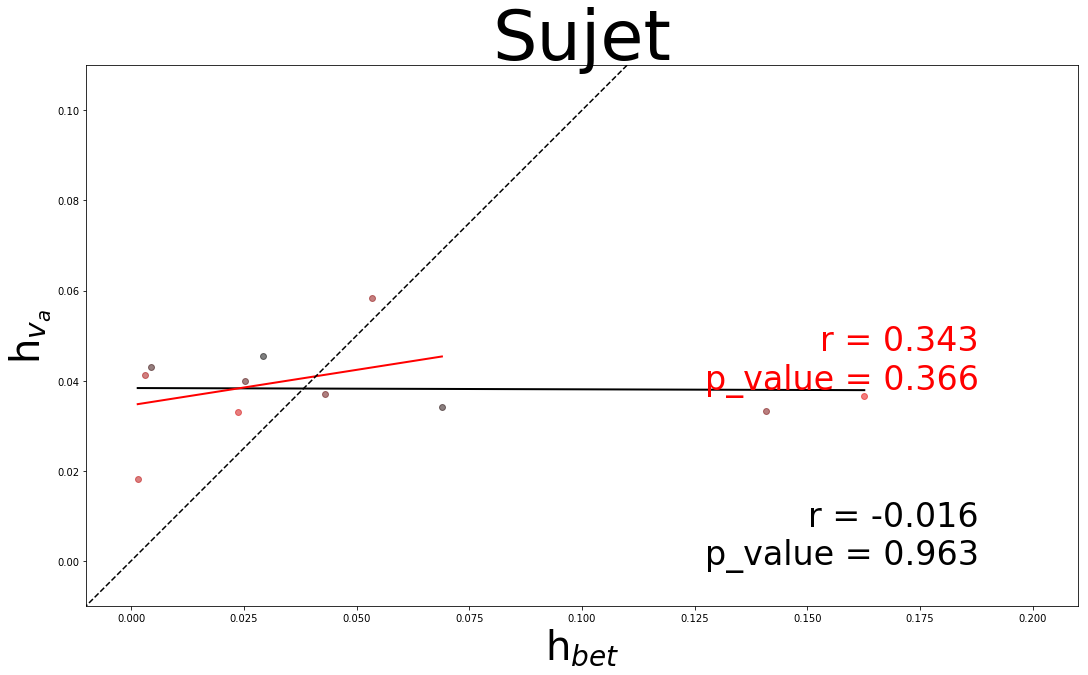

In [14]:
fig, axs = plt.subplots(1, 1, figsize=((fig_width), (fig_width)/(1.6180*1)), constrained_layout=True)

for x, color in enumerate(COLOR):
    axs.scatter(h_bet['sujet'][x], h_va['sujet'][x],color=color)

axs.set_title('Sujet', fontsize=t_titre)
axs.set_xlabel('h$_{bet}$', fontsize=t_label)
axs.set_ylabel('h$_{v_a}$', fontsize=t_label)
axs.axis([-0.01 ,0.21,-0.01,0.11])

regress(axs, h_bet['sujet'], h_va['sujet'], 'k', minx=-0.01, miny=-0.01, maxx=0.21, maxy=0.08)

Hva = h_va['sujet'].copy()
Hbet = h_bet['sujet'].copy()

del Hva[np.argmax(Hbet)]
del Hbet[np.argmax(Hbet)]
del Hva[np.argmax(Hbet)]
del Hbet[np.argmax(Hbet)]
regress(axs, Hbet, Hva, 'r', minx=-0.01, miny=0.03, maxx=0.21, maxy=0.11)

axs.plot(np.arange(-10,10), np.arange(-10,10), '--k')
plt.show()

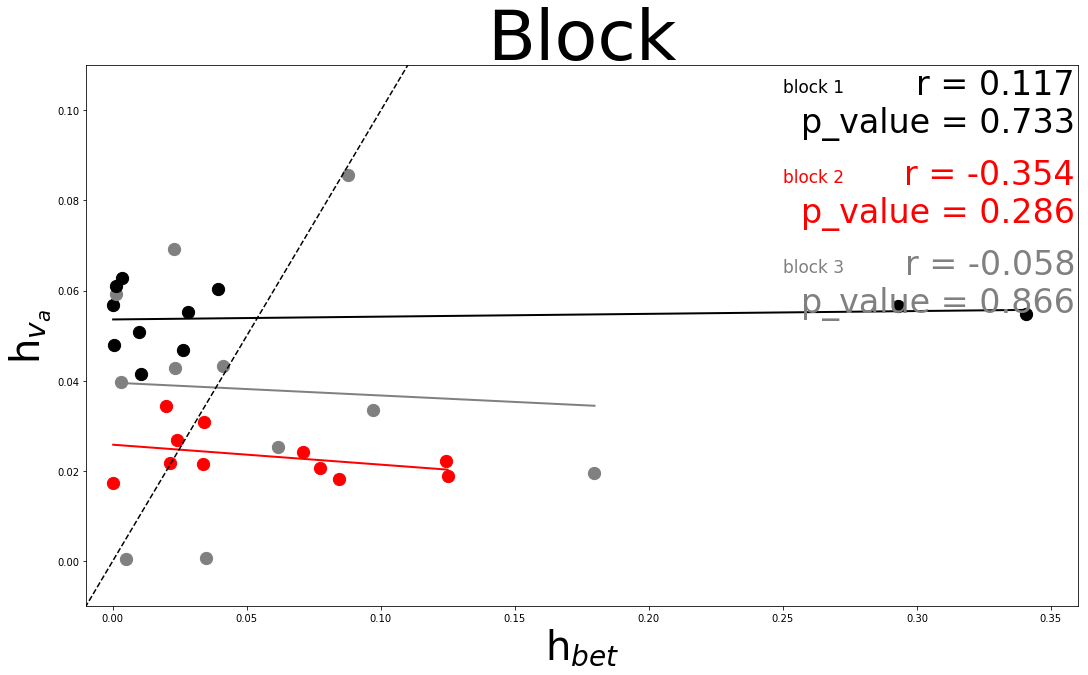

In [15]:
fig, axs = plt.subplots(1, 1, figsize=((fig_width), (fig_width)/(1.6180*1)), constrained_layout=True)

c = ['k', 'r', 'grey']

h_bet_block = []
h_va_block = []

for x, color in enumerate(COLOR):
    for a in range(len(h_bet['block'][x])) :
        axs.scatter(h_bet['block'][x][a], h_va['block'][x][a],color=c[a], s=150)
        if x==0:
            h_bet_block.append([])
            h_va_block.append([])
        h_bet_block[a].append(h_bet['block'][x][a])
        h_va_block[a].append(h_va['block'][x][a])

for a in range(len(h_bet_block)) :
    axs.text(0.25, 0.11-(0.02*(a)+((0.02*(a+3)-0.02*(a))/10)), 'block %s'%(a+1), color=c[a], fontsize=17)
    axs=regress(axs, h_bet_block[a], h_va_block[a], c[a], minx=-0.01, miny=0.10-(0.02*(a)), maxx=0.40, maxy=0.11-(0.02*(a+3)))

axs.set_title('Block', fontsize=t_titre)
axs.set_xlabel('h$_{bet}$', fontsize=t_label)
axs.set_ylabel('h$_{v_a}$', fontsize=t_label)
axs.axis([-0.01 ,0.36,-0.01,0.11])

axs.plot(np.arange(-10,10), np.arange(-10,10), '--k')
plt.show()

Moyenne par block


/usr/local/lib/python3.7/site-packages/matplotlib/figure.py:2144: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  warnings.warn("This figure was using constrained_layout==True, "


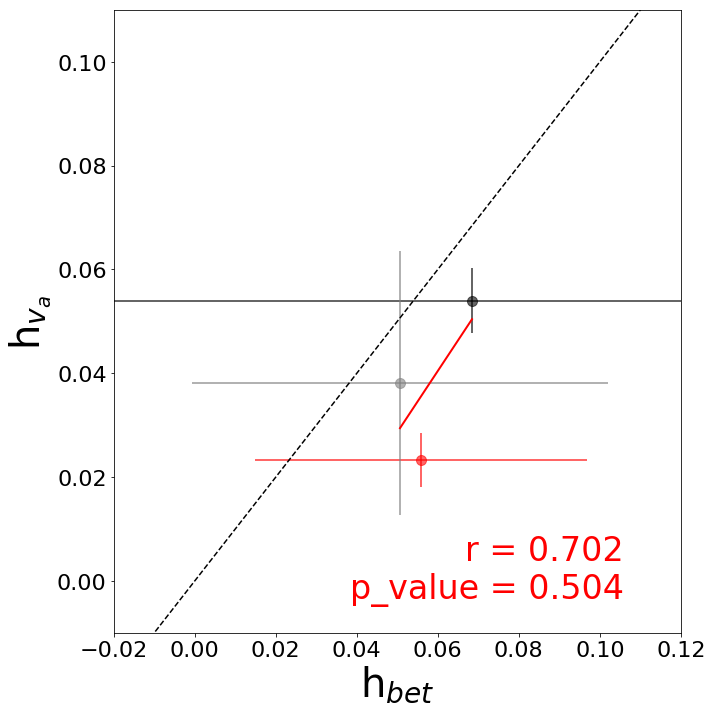

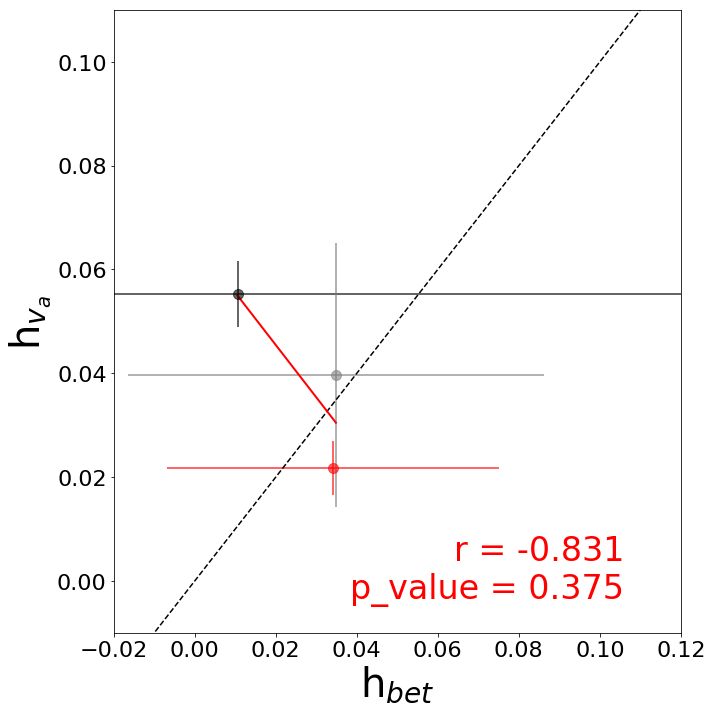

In [16]:
print('Moyenne par block')
fig, axs = scatter_mean(h_bet_block, h_va_block, '', maxx=0.1, maxy=0.1, color=c)
fig, axs = scatter_mean(h_bet_block, h_va_block, '', maxx=0.1, maxy=0.1, mean='mediane', color=c)

#fig1, axs1 = scatter_mean(h_bet_block, h_va_block, '', maxx=0.1, maxy=0.1, ellipse=True)

In [17]:
exts = ['.png', '.svg', '.pdf']

Moyenne par Sujet block
10 DC
5 CS


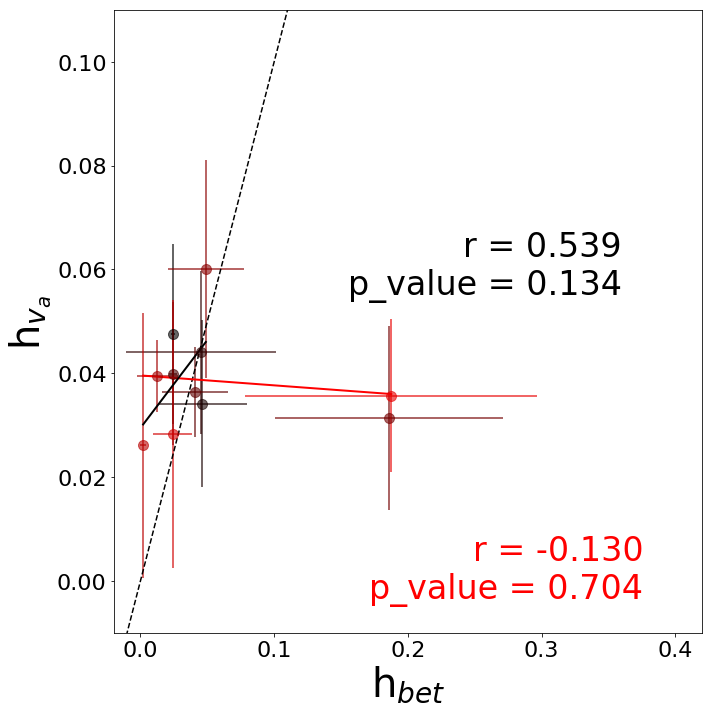

5 CS
9 IP


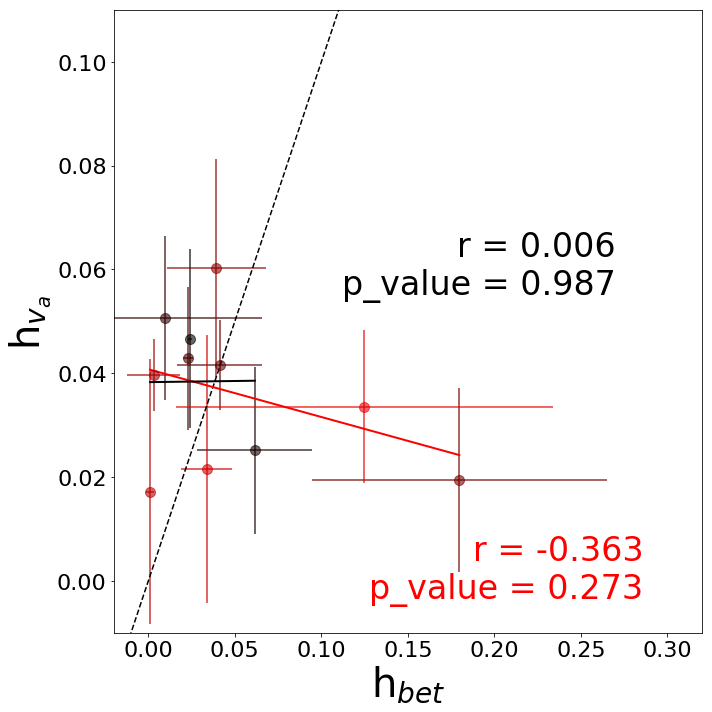

In [18]:
print('Moyenne par Sujet block')
fig, axs = scatter_mean(h_bet['block'], h_va['block'], '', maxx=0.4, maxy=0.1, supp=True, color=COLOR)
#for ext in exts: fig.savefig('ms/figures/5_inter-individual_differences_fit' + ext, dpi=400)

fig, axs = scatter_mean(h_bet['block'], h_va['block'], '', maxx=0.3, maxy=0.1, mean='mediane', supp=True, color=COLOR)

##fig1, axs1 = scatter_mean(h_bet['block'], h_va['block'], '', maxx=0.4, maxy=0.1, ellipse=True)

Moyenne par Sujet pause


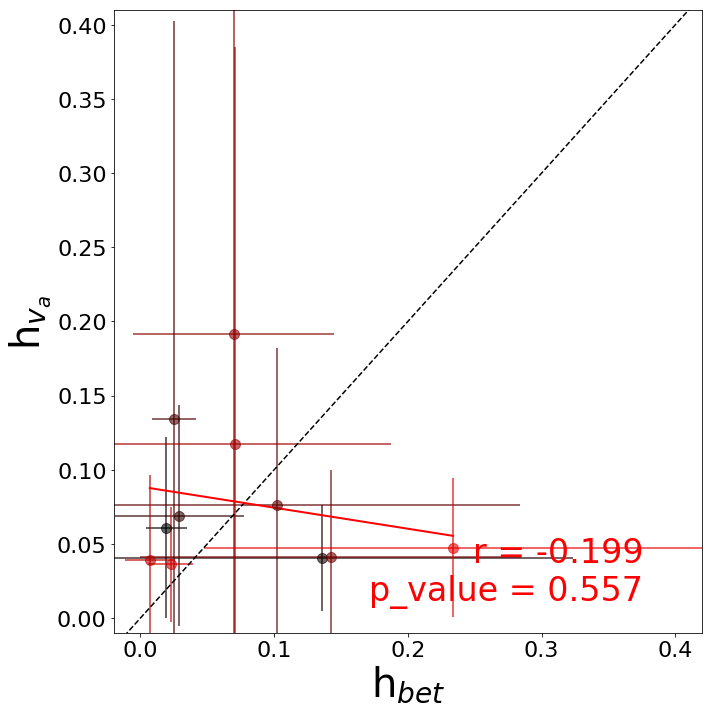

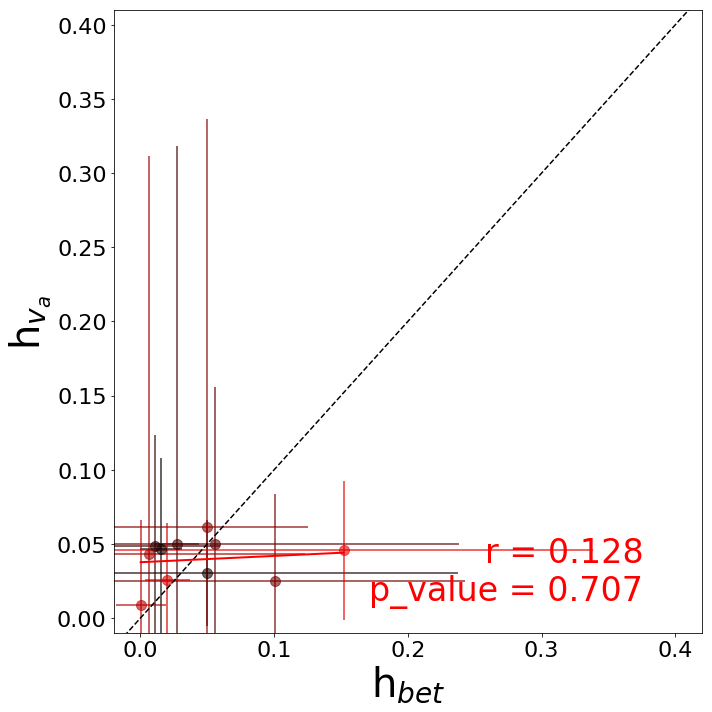

In [19]:
print('Moyenne par Sujet pause')
fig, axs = scatter_mean(h_bet['pause'], h_va['pause'], '',maxx=0.4, maxy=0.4, color=COLOR)
fig, axs = scatter_mean(h_bet['pause'], h_va['pause'], '',maxx=0.4, maxy=0.4, mean='mediane', color=COLOR)
##fig1, axs1 = scatter_mean(h_bet['pause'], h_va['pause'], '',maxx=0.4, maxy=0.4, ellipse=True)

## MI

In [20]:
# https://matthew-brett.github.io/teaching/mutual_information.html
def mutual_information(hgram):
    """ Mutual information for joint histogram"""
    # Convert bins counts to probability values
    pxy = hgram / float(np.sum(hgram))
    px = np.sum(pxy, axis=1) # marginal for x over y
    py = np.sum(pxy, axis=0) # marginal for y over x
    px_py = px[:, None] * py[None, :] # Broadcast to multiply marginals
    # Now we can do the calculation using the pxy, px_py 2D arrays
    nzs = pxy > 0 # Only non-zero pxy values contribute to the sum
    return np.sum(pxy[nzs] * np.log(pxy[nzs] / px_py[nzs]))

In [21]:
fig_width = 15
t_titre = 70
t_label = 30*4

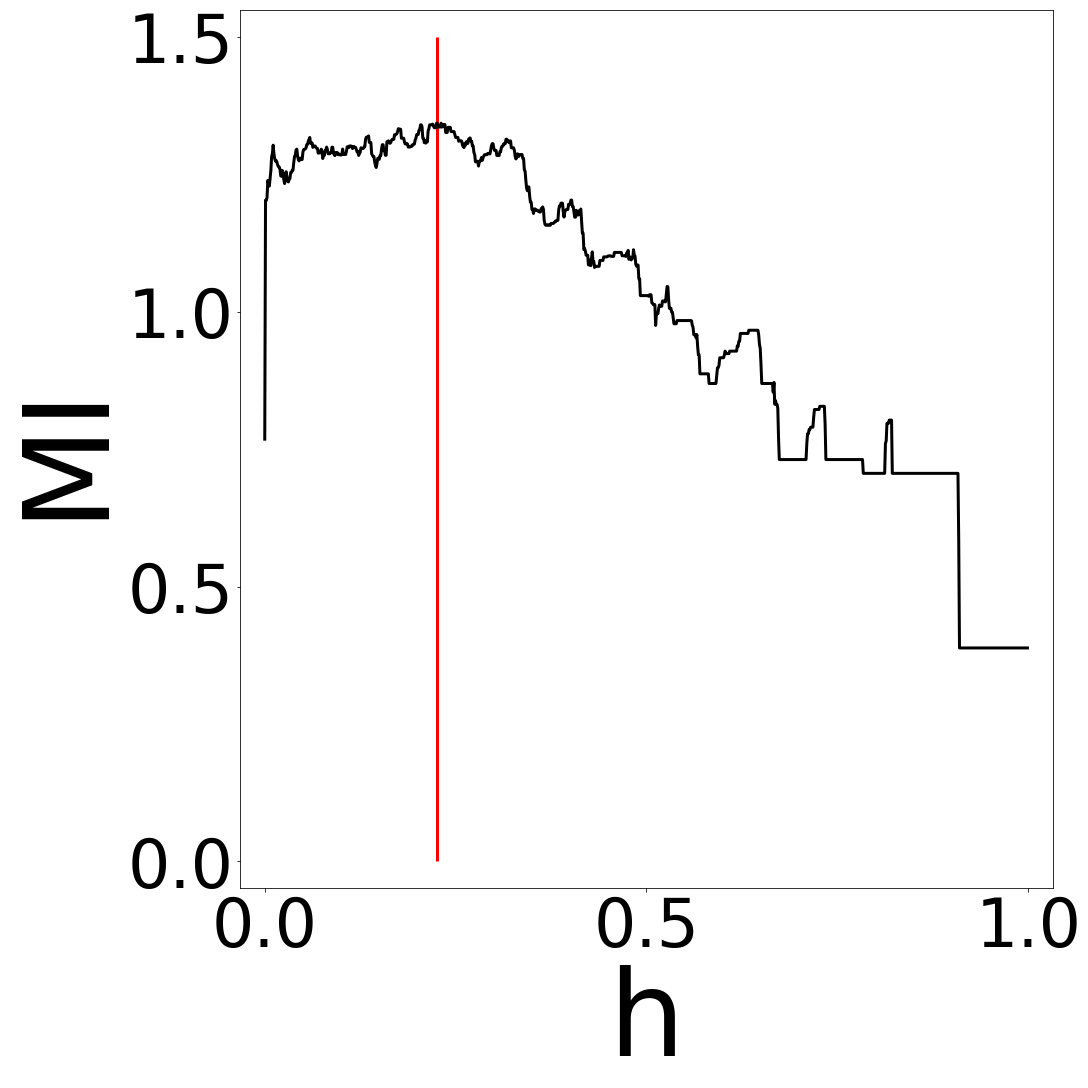

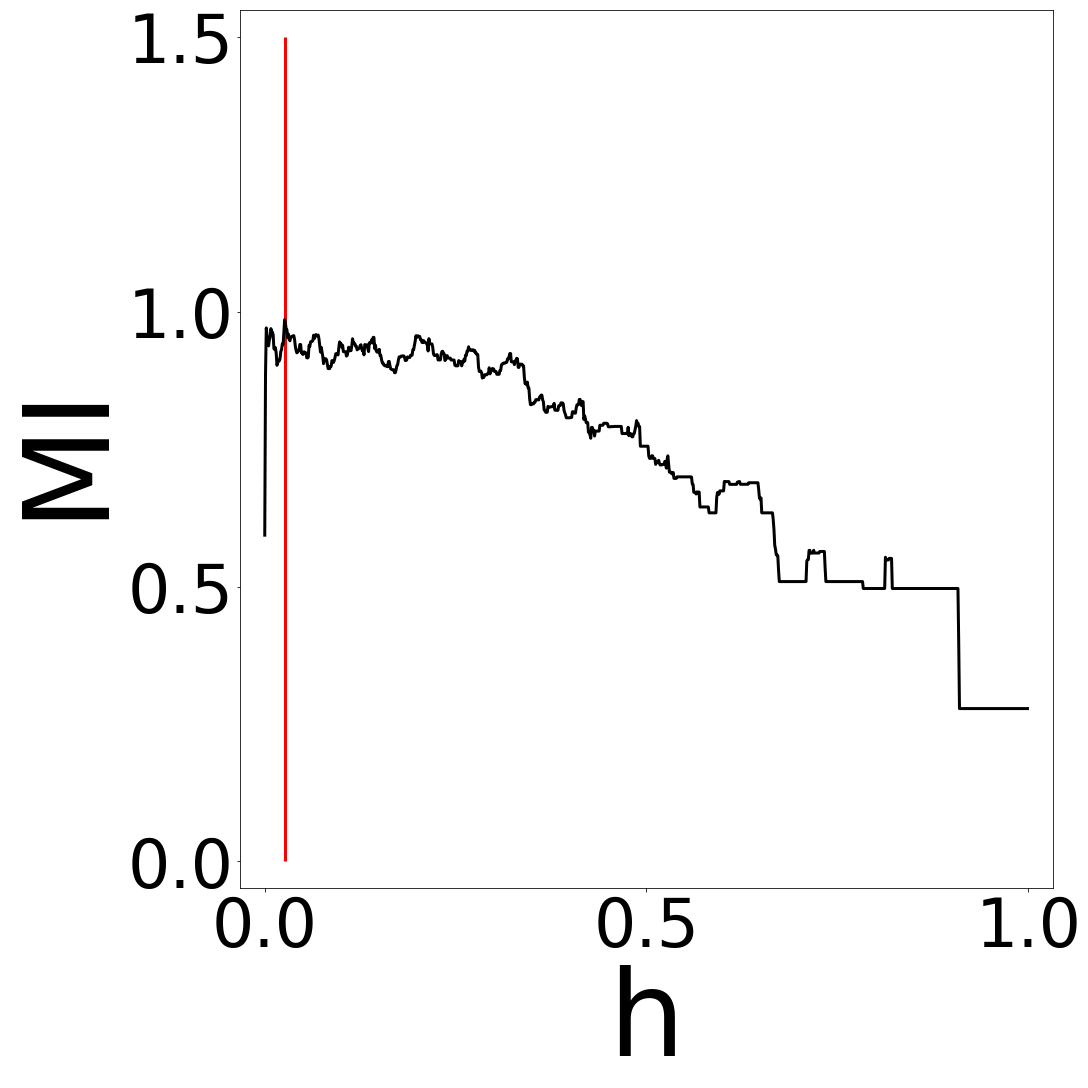

In [22]:
mi_h_bet_block, mi_h_va_block = [], []
mimi_bet_block, mimi_va_block = [], []

for x in range(len(exp)) :
    
    prob_sujet, bet_sujet, a_anti_sujet = [], [], []
    
    p = exp[x]['p']
    tau = exp[x]['N_trials']/5.
    h = 1./tau 
    hs = np.arange(0,1,0.001) #h*np.logspace(-1., 1., 50)
    
    bet = (exp[x]['results']+1)/2 # results est sur [-1,1] on le ramene sur [0,1]
    a_anti = param[x]['a_anti']
    latency = param[x]['latency']
    start_anti = param[x]['start_anti']
     
    mi_h_bet_block.append([])
    mi_h_va_block.append([])
    
    mimi_bet_block.append([])
    mimi_va_block.append([])

    for block in range(exp[x]['N_blocks']):
        va = (np.array(a_anti[block])*((np.array(latency[block])-np.array(start_anti[block]))/1000))
        prob_block = p[:, block, 0]
        
        mi_bet = np.ndarray(len(hs))
        mi_va = np.ndarray(len(hs))

        for H in range(len(hs)):
            p_hat = fct_BCP(prob_block, hs[H])
            p_hat_nan = np.ma.masked_array(p_hat, mask=np.isnan(va)).compressed()
            va_nan = np.ma.masked_array(va, mask=np.isnan(va)).compressed()
            
            hist_bet, x_edges, y_edges = np.histogram2d(p_hat,bet[:, block],bins=20)
            hist_va, x_edges, y_edges = np.histogram2d(p_hat_nan,va_nan,bins=20)

            mi_bet[H] = mutual_information(hist_bet)
            mi_va[H] = mutual_information(hist_va)
                            
        tutu_bet = mi_bet.argmax()
        tutu_va = mi_va.argmax()
        
        if x==5 :
            if block==1:
                fig, axs = plt.subplots(1, 1, figsize=((fig_width), (fig_width)), constrained_layout=True)#/(1.6180*1)))
                axs.vlines(hs[tutu_bet], 0, 1.5, colors='r', lw=3) 
                axs.plot(hs, mi_bet, c='k', lw=3)
                axs.axis([-0.032 , 1.032,-0.048,1.548])
                axs.set_xlabel('h', fontsize=t_label)
                axs.set_ylabel('MI', fontsize=t_label)
                axs.tick_params(axis='both', labelsize=t_label/1.8)
                #for ext in exts: fig.savefig('ms/figures/5_A_h_bet' + ext, dpi=400)
                
                fig, axs = plt.subplots(1, 1, figsize=((fig_width), (fig_width)), constrained_layout=True)#/(1.6180*1)))
                axs.vlines(hs[tutu_va], 0, 1.5, colors='r', lw=3) 
                axs.plot(hs, mi_va, c='k', lw=3)
                axs.axis([-0.032 , 1.032,-0.048,1.548])
                axs.set_xlabel('h', fontsize=t_label)
                axs.set_ylabel('MI', fontsize=t_label)
                axs.tick_params(axis='both', labelsize=t_label/1.8)
                #for ext in exts: fig.savefig('ms/figures/5_A_h_va' + ext, dpi=400)
                
        mi_h_bet_block[x].append(hs[tutu_bet])
        mi_h_va_block[x].append(hs[tutu_va])

        mimi_bet_block[x].append(mi_bet[tutu_bet])
        mimi_va_block[x].append(mi_va[tutu_va])

Moyenne par Sujet block


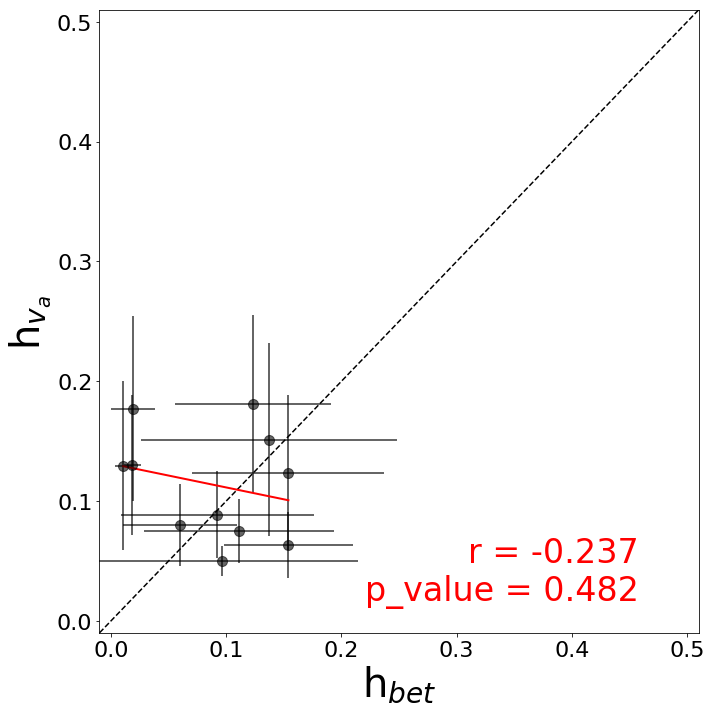

In [23]:
print('Moyenne par Sujet block')
fig_width = 15
t_titre = 70
t_label = (30*4)/3
fig, axs = scatter_mean(mi_h_bet_block, mi_h_va_block, '', maxx=0.5, maxy=0.5, ex=0.01, ey=0.01)
fig.tight_layout()
#for ext in exts: fig.savefig('ms/figures/5_inter-individual_differences_MI' + ext, dpi=400)
    
##fig1, axs1 = scatter_mean(mi_h_bet_block, mi_h_va_block, '', maxx=0.5, maxy=0.5, ex=0.01, ey=0.01, ellipse=True)
##fig1.tight_layout()